# Camera Calibration

In [1]:
#Import needed Libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#Chessboard
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )


## Visualize calibration

Text(0.5,1,'Undistorted Image')

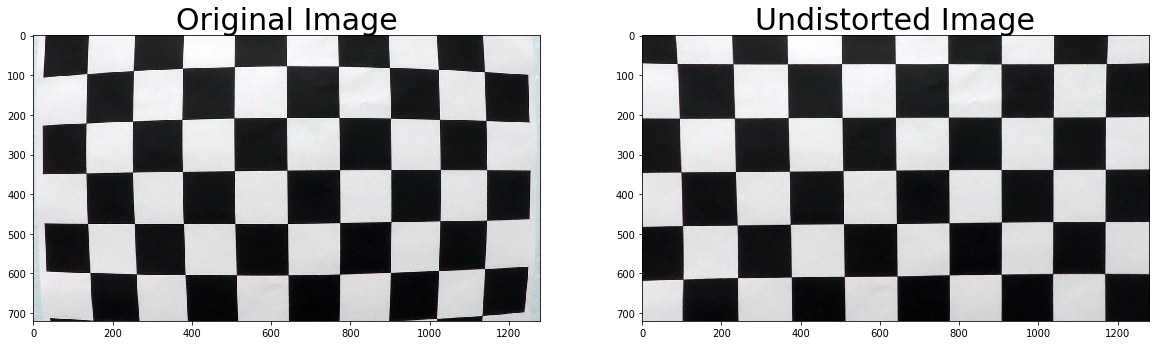

In [2]:
#Load calibration parameters previously found
with open('wide_dist_pickle.p', 'rb') as f:
    data = pickle.load(f)

dist = data['dist']
mtx =  data['mtx']

# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
undist = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

# Image warping

In [3]:
def warp(img, roi):
    '''This function takes as parameter the image to be transformed
        and the Region of Interest (roi).
        Roi must be a tuple (x1,x2,y1,y2)
    '''
    img_size=(img.shape[1], img.shape[0])
    
    #This values were chosen by looking at the pixels in an image editor.
    src=np.float32([
        [696,455],
        [1038,675],
        [280,675],
        [588,455]])
    
    dst=np.float32([
        [700,350],
        [700,700],
        [500,700],
        [500,350]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped[roi[2]:roi[3],roi[0]:roi[1]]

## Visualization of image warped

Text(0.5,1,'Warped Image')

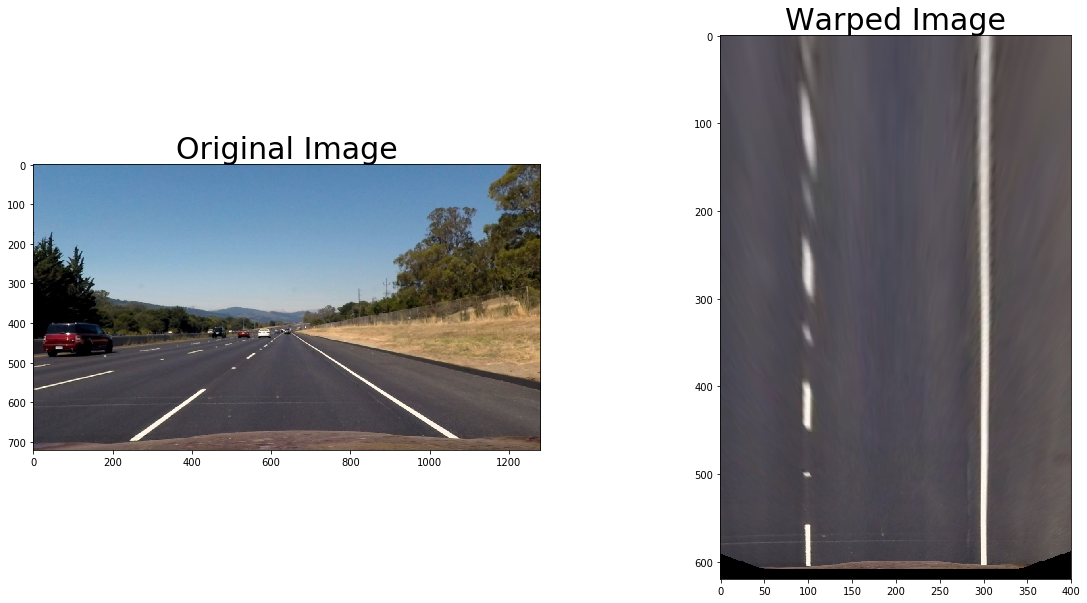

In [4]:
import matplotlib.image as mpimg

#Get Perspective transform
#Read image example
img = mpimg.imread('./test_images/straight_lines2.jpg')
#Undistort image
undist_test = cv2.undistort(img, mtx, dist, None, mtx)
#Choose roi to crop
roi = (400,800,100,img.shape[0])
warped_im=warp(undist_test, roi)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist_test)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped_im)
ax2.set_title('Warped Image', fontsize=30)

# Trhesholding

In [5]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def thresholding(img, s_thresh=(150, 210), sx_thresh=(40, 150)):
    img = np.copy(img)
    img_blur = gaussian_blur(img[:,:,0],9)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    #sobelx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobelx = cv2.Sobel(img[:,:,0], cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return np.uint8((s_binary == 1) | (sxbinary == 1))
    

## Visualize thresholding

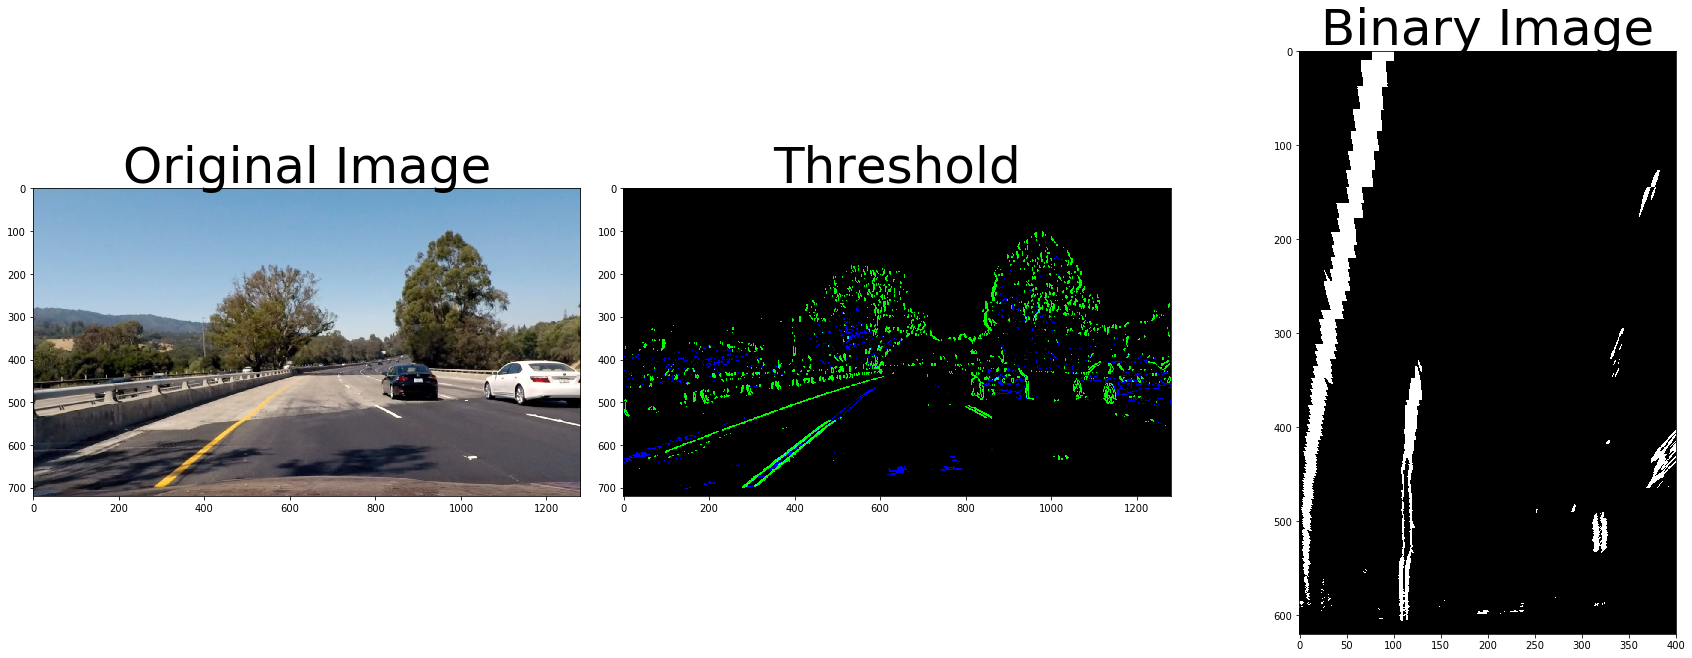

In [7]:

# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('./test_images/test4.jpg')
image = cv2.undistort(image, mtx, dist, None, mtx)

img_blur = gaussian_blur(image[:,:,0],9)

s_thresh=(150, 210)
sx_thresh=(40, 150)

# 1) Convert to HLS color space
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
# 2) Apply a threshold to the S channel
s_channel = hls[:,:,2]

sobelx = cv2.Sobel(img_blur, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

# Threshold color channel
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
# Stack each channel
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
#Convert to binary, I just used and or operator
binary_thresh = np.uint8((s_binary == 1) | (sxbinary == 1))

warped_img = warp(binary_thresh,roi)


# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(color_binary, cmap='gray')
ax2.set_title('Threshold', fontsize=50)
ax3.imshow(warped_img, cmap='gray')
ax3.set_title('Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Find Curvature

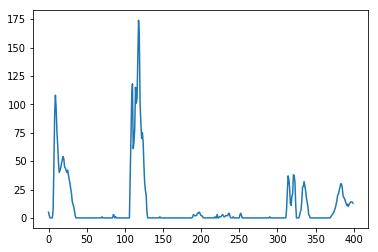

In [8]:
#First step, calculate histogram of white pixels
undist_test = cv2.undistort(image, mtx, dist, None, mtx)
thresh_img = thresholding(undist_test)
warped_img = warp(thresh_img,roi)
binary_warp = warped_img

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    h,w =img.shape
    bottom_half = img[h//2:,:]
    # TSum across image pixels vertically
    histogram = np.sum(bottom_half, axis=0)
    return histogram

# Create histogram of image binary activations
histogram = hist(binary_warp)

# Visualize the resulting histogram
plt.plot(histogram)

## Fit Polynomial

1959.927824204135 1471.6015940827479 0.13829126263224012


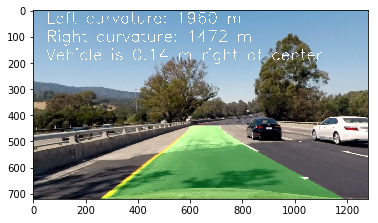

In [34]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/620 # meters per pixel in y dimension
xm_per_pix = 4/400 # meters per pixel in x dimension

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 7
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped, undist_test):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    #Determine Radious
    y_eval_left = np.max(lefty)
    y_eval_right = np.max(righty)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval_left + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval_right + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate vehicle center
    xMax = binary_warped.shape[1]*xm_per_pix
    yMax = binary_warped.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter

    print(left_curverad, right_curverad,diffFromVehicle)
    ## Visualization ##
    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(img).astype(np.uint8)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([400+left_fitx, 100+ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([400+right_fitx, 100+ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    src=np.float32([
        [696,455],
        [1038,675],
        [280,675],
        [588,455]])

    dst=np.float32([
        [700,350],
        [700,700],
        [500,700],
        [500,350]])

    Minv = cv2.getPerspectiveTransform(dst, src)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_test, 1, newwarp, 0.3, 0)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale=2
    fontColor = (255, 255, 255)
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(result, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)

    return result


out_img = fit_polynomial(binary_warp, undist_test)

plt.imshow(out_img)

# Video PipeLine so far

In [35]:
def pipeline_process(img_video):
    undist_test = cv2.undistort(img_video, mtx, dist, None, mtx)
    binary_img = thresholding(undist_test)
    binary_warp = warp(binary_img,roi)
    out_img = fit_polynomial(binary_warp, undist_test)
    return out_img


In [36]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [37]:
white_output = 'output_images/out0.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4').subclip(0,5)
white_clip = clip1.fl_image(pipeline_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   2%|▏         | 3/125 [00:00<00:06, 20.07it/s, now=None]

1712.242241097798 2225.9884386815124 0.20717672111540164
Moviepy - Building video output_images/out0.mp4.
Moviepy - Writing video output_images/out0.mp4

1712.242241097798 2225.9884386815124 0.20717672111540164
1708.0718318607776 1733.7115178311853 0.1941898529116033


t:   4%|▍         | 5/125 [00:00<00:06, 17.78it/s, now=None]

1673.8745401531467 1903.627915825344 0.2042358122482426
1581.7647502312657 1845.8410197102558 0.1992019088714283
1610.8161849624084 2102.3826343142296 0.20997599344653706
1590.2445780783607 2102.9354362604154 0.2124219464184698


t:   7%|▋         | 9/125 [00:00<00:07, 15.91it/s, now=None]

1636.3938442708281 2322.5649123570006 0.22261047001029421
1613.28631259941 1832.2019932954033 0.21047913959948872
1712.0650289224875 1817.0221604655142 0.20791555413962115
1686.078959875939 1885.1956109519167 0.2092508935942936


t:  10%|█         | 13/125 [00:00<00:07, 15.29it/s, now=None]

1585.5244627061852 1620.9976186206704 0.18869433462308072
1882.6246626824925 2197.970069141279 0.2154155826347628
1825.4571159979482 2207.9517534063716 0.21338906286697767
1648.1382925313678 2122.7716597653016 0.20332436611871518


t:  14%|█▎        | 17/125 [00:01<00:07, 14.92it/s, now=None]

1468.6544089648962 1650.305209280446 0.18287429752032036
1320.4841978957193 1802.0160974179844 0.17770717433850436
1215.1027584437904 1676.7055108878421 0.14819139682302485
1128.3066057804272 1420.5603309175763 0.11891897674641605


t:  17%|█▋        | 21/125 [00:01<00:06, 15.00it/s, now=None]

1170.2656344380985 1499.7361466552595 0.12130734736586701
1178.0469137884154 1418.827649236042 0.10970740677558855
1247.314401117874 1354.9369285936768 0.09973416101483767
1299.3837247921265 1646.9340209771538 0.1210093928553162


t:  20%|██        | 25/125 [00:01<00:06, 14.93it/s, now=None]

1384.3505782313873 1960.3258335347998 0.13688358192020367
1274.2202764054296 1602.3052358908105 0.1214882932488317
1305.3875588928854 1564.87227365059 0.13209548002219362
1416.9308182819389 1789.7400519761288 0.1473989936567519


t:  23%|██▎       | 29/125 [00:01<00:06, 14.82it/s, now=None]

1411.5737714384088 1698.9537297078766 0.14462155049435932
1484.1099887009211 1773.950003560507 0.14698546498543852
1376.4881342398057 1758.4262813446621 0.14479623762589178
1298.485053510323 1427.7740858377495 0.1338954379674515


t:  26%|██▋       | 33/125 [00:02<00:06, 13.50it/s, now=None]

1220.2793635666142 1419.2774414990313 0.14105115808265367
1146.5390745193433 1479.960449858306 0.14693074149490393
1204.2139904037933 1473.9407008025062 0.1445266041394042


t:  30%|██▉       | 37/125 [00:02<00:06, 13.36it/s, now=None]

1180.9830535487552 1225.0594686011757 0.13721899929496928
1174.8805798934006 1218.3761495717577 0.1421777583995949
1155.4104480585581 1434.4555167224985 0.1609883266878045


t:  31%|███       | 39/125 [00:02<00:06, 12.85it/s, now=None]

1158.794496321659 1462.4152521914914 0.16505528276099035
1180.8784838804318 1379.5699576249044 0.17250697014977856
1126.4027110468974 1334.782744510968 0.16803232011365932


t:  34%|███▍      | 43/125 [00:03<00:06, 13.15it/s, now=None]

1202.8929961376048 1371.8824855789112 0.17796753430872547
1237.2838141558236 1260.3143423052254 0.17217444331329368
1239.6510033517832 1183.8549056649208 0.1667200735749379


t:  36%|███▌      | 45/125 [00:03<00:06, 12.41it/s, now=None]

1332.1515495263372 1239.28081620321 0.17716921760673054
1474.6096450063383 1367.5638235566803 0.18674519948300006


t:  38%|███▊      | 47/125 [00:03<00:07, 10.87it/s, now=None]

1509.0213454811324 1349.603031041187 0.18961859448220597
1619.890104005567 1681.841630173676 0.20909743589503682


t:  39%|███▉      | 49/125 [00:03<00:07, 10.18it/s, now=None]

1664.1169346079068 1597.1563358858232 0.20119671298617003
1601.7484990390615 1627.2600963313357 0.19918013812909585


t:  41%|████      | 51/125 [00:03<00:07, 10.36it/s, now=None]

1739.9281568450933 1777.5301628718184 0.20225712209979285
1756.7633704887662 1569.4961023018368 0.1929492134408468
1807.1467684418215 1756.5284435239 0.1997034613596167


t:  42%|████▏     | 53/125 [00:04<00:07, 10.13it/s, now=None]

1700.4336282847746 1531.4496855872603 0.18805935825594755
1678.650226441144 1451.8969838596083 0.17855426136366992


t:  46%|████▌     | 57/125 [00:04<00:06, 10.49it/s, now=None]

1632.1402484724981 1490.453053584831 0.1758061529253836
1672.665017224713 1392.019953699227 0.17110386270327815
1837.0891224385082 1378.8122323561508 0.16558746082396691


t:  47%|████▋     | 59/125 [00:04<00:05, 11.03it/s, now=None]

1750.2986971152977 1395.0790848025388 0.1638457339225199
1710.0243555246666 1421.5918223261285 0.15665870575491914
1499.6288120293402 1320.794931587112 0.14181742250553064


t:  50%|█████     | 63/125 [00:04<00:05, 11.39it/s, now=None]

1431.8086874029577 1215.9876211118235 0.1348919248134255
1360.990406655066 1337.4609495798707 0.13967867585757032
1262.6039803375813 1113.3308273585421 0.11186944967326795


t:  52%|█████▏    | 65/125 [00:05<00:05, 11.47it/s, now=None]

1335.6150316463054 1132.6829323852091 0.10679172126712722
1286.7758300982605 1427.4361475298288 0.13195715231734884
1351.4886691628828 1421.0156324403586 0.1254893717687695


t:  55%|█████▌    | 69/125 [00:05<00:04, 11.76it/s, now=None]

1371.4299569351326 1201.2430687784015 0.11236412465986767
1330.0979861842643 1167.7457260500496 0.09679961560201811
1374.5209449151216 1216.8551466744325 0.09743138873851853


t:  57%|█████▋    | 71/125 [00:05<00:04, 11.73it/s, now=None]

1300.1502246950154 1089.1785063987115 0.08298156513191923
1382.1175725910616 1216.5700709876132 0.08870942576486485
1307.6352222277915 1044.8827534911502 0.061846684950178865


t:  60%|██████    | 75/125 [00:05<00:04, 11.96it/s, now=None]

1372.836183830513 1400.9440932033233 0.09423910827591975
1363.702348934272 1394.2513312704975 0.09047522680307107
1371.0545904831783 1216.6833126423423 0.07382820386896238


t:  62%|██████▏   | 77/125 [00:06<00:03, 12.14it/s, now=None]

1488.0897725533046 1440.7334402693054 0.08811680848642212
1440.8384580372267 1264.2435272978016 0.0746884511637198
1593.2704142588864 1462.0629271201458 0.08464741414019805


t:  65%|██████▍   | 81/125 [00:06<00:03, 12.24it/s, now=None]

1625.8479937295415 1583.8072032444409 0.08756439548946382
1706.9485026710165 1541.547575653971 0.08428698119491251
1642.4469504524704 1624.0990425842733 0.07831492223927672


t:  66%|██████▋   | 83/125 [00:06<00:03, 11.99it/s, now=None]

1541.9391582728442 1458.0563347942254 0.06627254704132568
1558.5448878879834 1480.8363033849275 0.06281685685775251
1526.5219712320672 1523.343069218306 0.05751028394116986


t:  68%|██████▊   | 85/125 [00:06<00:03, 11.41it/s, now=None]

1749.0218036541655 1983.5846725272334 0.08022416332283333
1611.124967910505 1860.2229845060992 0.0693327272669908
1599.9631592191283 1627.8222661059144 0.0625896140758142


t:  71%|███████   | 89/125 [00:07<00:03, 11.03it/s, now=None]

1307.3694327272847 1311.9743039933937 0.03433379369108058
1213.1275482935107 1341.9297205151377 0.044491303194900134
1126.7509818965964 1326.3040711526523 0.04000961309044815


t:  74%|███████▍  | 93/125 [00:07<00:02, 11.40it/s, now=None]

1028.2044473821525 1360.018309612471 0.052935839449641975
1064.0431837191018 1096.9587061761556 0.026304365379496986
1097.8990957989772 1131.8008954593247 0.03442141939522614


t:  76%|███████▌  | 95/125 [00:07<00:02, 10.43it/s, now=None]

1045.1066475703124 2283.5932371412537 0.08791844449227204
1028.2488742540702 1157.3866090701856 0.039343945926599844


t:  78%|███████▊  | 97/125 [00:08<00:03,  8.99it/s, now=None]

1087.360365906301 1242.2209984463598 0.03821411121046747
1108.7231097295073 1201.096009502998 0.03299800543599929


t:  80%|████████  | 100/125 [00:08<00:02,  9.79it/s, now=None]

1104.099824502355 1084.3171410202376 0.022937797183405717
1145.3088726299914 1285.1137721157388 0.04574848823716238
1097.1371275894692 1090.1046825747458 0.030384187788556893


t:  82%|████████▏ | 102/125 [00:08<00:02, 10.26it/s, now=None]

1146.8923891863528 1150.7368449812395 0.039185274187780283
1137.2370000221224 1140.4427382447018 0.04902460940995379
1105.3688213060227 1132.5801589864602 0.046734214955476805


t:  83%|████████▎ | 104/125 [00:08<00:01, 10.63it/s, now=None]

1107.5062331528195 1109.1727170771776 0.05126891345338702
1116.964060860977 1135.5049484608026 0.05952579079250597
1174.9037188162263 1444.1255699971887 0.0754013094817032


t:  86%|████████▋ | 108/125 [00:08<00:01, 11.10it/s, now=None]

1247.9060315229003 1241.965792933375 0.07513589368304663
1282.758425487655 1410.08236981507 0.088575508922911
1217.2580184788617 1198.8648779609669 0.08017157958829912


t:  90%|████████▉ | 112/125 [00:09<00:01, 11.62it/s, now=None]

1232.1318529439786 1218.7508189358202 0.08396303000191363
1216.3887730628248 1186.9938000141312 0.08270013168545187
1211.1522556273767 1254.5056759599263 0.09279910261258761


t:  91%|█████████ | 114/125 [00:09<00:00, 11.72it/s, now=None]

1315.61032476382 1330.4895328934813 0.10145472559410695
1224.176904806083 1313.3673930472698 0.10320997597854653
1205.3525207003815 1214.028579008018 0.10289692402918593


t:  94%|█████████▍| 118/125 [00:09<00:00, 11.54it/s, now=None]

1140.3458349206767 1155.875311771404 0.10466566757315032
1135.9563983767307 1197.0738222680639 0.11331746484343697
1170.984813501704 1191.1215646627497 0.11578094103078573


t:  96%|█████████▌| 120/125 [00:10<00:00, 11.30it/s, now=None]

1194.1792900780483 1082.8748986282467 0.11282009659846093
1200.3416429917902 1153.23471656597 0.12282613055517988
1178.0923534827036 1148.6520407941566 0.13449471813395686


t:  99%|█████████▉| 124/125 [00:10<00:00, 12.16it/s, now=None]

1205.681653337364 1220.260838544652 0.14355852003237057
1191.280222080407 1277.661153790605 0.15320819245847828
1172.4362906792082 1261.707299789798 0.14952826805379438


1180.7980839849038 1153.7683016550907 0.14509697637257624
1165.6344797564634 1141.97877833993 0.14393380380400256
Moviepy - Done !
Moviepy - video ready output_images/out0.mp4
CPU times: user 15.6 s, sys: 1.36 s, total: 17 s
Wall time: 11.8 s
